# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## 1 Подготовка данных

### 1.1 Загрузка данных

Начнём работу с данными с импорта библиотек.

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.preprocessing import OrdinalEncoder 
from lightgbm import LGBMRegressor


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV


import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings("ignore")

In [2]:
path_data = "/datasets/autos.csv"

if os.path.exists(path_data):
    data = pd.read_csv(path_data)
else:
    print('Что-то не так!')

Рассмотрим эти данные и проведём предобработку, если таковая потребуется.

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### 1.2 Предобработка данных

Столбцы `DateCrawled`, `RegistrationMonth`, `DateCreated`, `NumberOfPictures`, `PostalCode` и `LastSeen` относятся к параметрам анкеты на сайте, они никак не влияют на рыночную стоимость автомобиля. Следовательно, они не нужны для нашей задачи, поэтому можно удалить их. Но сначала избавимся от явных дубликатов, если такие имеются.

In [5]:
data.duplicated().sum()

4

In [6]:
data.drop_duplicates(inplace = True)  

Теперь, когда были удалены явные дубликаты, можно удалить неважные столбцы.

In [7]:
data = data.drop(["DateCrawled", "RegistrationMonth", "DateCreated", "NumberOfPictures", "PostalCode", "LastSeen"], axis = 1)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354365 non-null  int64 
 1   VehicleType       316875 non-null  object
 2   RegistrationYear  354365 non-null  int64 
 3   Gearbox           334532 non-null  object
 4   Power             354365 non-null  int64 
 5   Model             334660 non-null  object
 6   Kilometer         354365 non-null  int64 
 7   FuelType          321470 non-null  object
 8   Brand             354365 non-null  object
 9   Repaired          283211 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


Далее следует рассмотреть каждый из оставшихся признаков отдельно.

#### Признак `Price`

In [9]:
data['Price'].value_counts()

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64

В столбце есть нулевые значения, но цена не может быть равна 0.

In [10]:
data = data.query('Price != 0')

In [11]:
data['Price'].value_counts()

500      5670
1500     5394
1000     4648
1200     4594
2500     4438
         ... 
5240        1
13180       1
10879       1
2683        1
8188        1
Name: Price, Length: 3730, dtype: int64

Рассмотрим ящик с усами для признака и посмотрим на 5%-ые квантили.

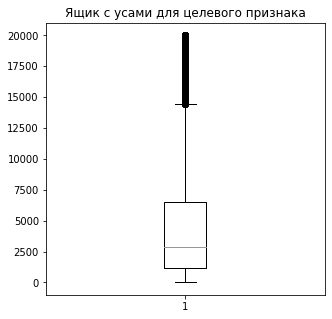

In [12]:
plt.figure(figsize = (5, 5))

plt.boxplot(data['Price'])
plt.title('Ящик с усами для целевого признака')
plt.show()

In [13]:
print(data['Price'].quantile(0.05))
print(data['Price'].quantile(0.95))

350.0
14800.0


Уберём эти 10% данных с выбросами.

In [14]:
data = data.query('350 < Price')

#### Признак `VehicleType`

Нужно разобраться с пропусками в этом столбце, заменим их на `other`.

In [15]:
data['VehicleType'] = data['VehicleType'].fillna('other')
data['VehicleType'].value_counts()

sedan          86757
small          70976
wagon          61771
other          31496
bus            28009
convertible    19670
coupe          15097
suv            11734
Name: VehicleType, dtype: int64

#### Признак `RegistrationYear`

In [16]:
years = data.pivot_table(index = 'RegistrationYear', values = 'Model', aggfunc='count')
years.columns = ['Number of cars']

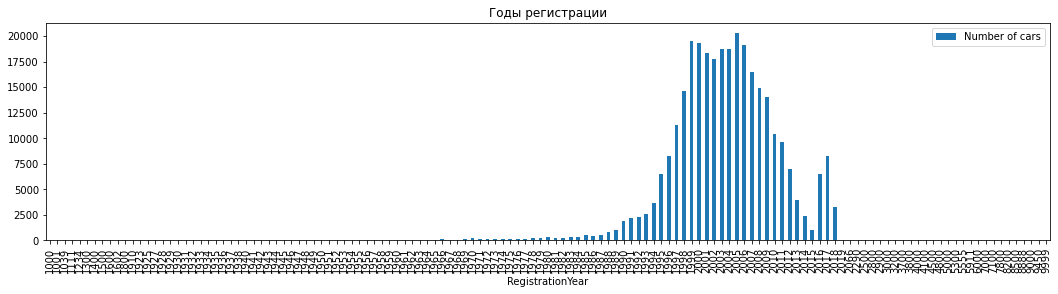

In [17]:
years.plot.bar(figsize = (18, 4))
plt.title('Годы регистрации')
plt.show()

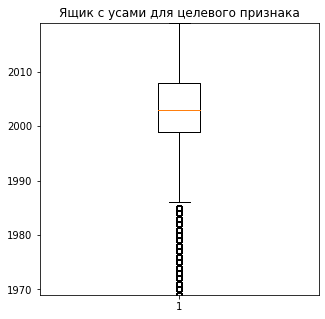

In [18]:
plt.figure(figsize = (5, 5))
plt.ylim([1969, 2019])

plt.boxplot(data['RegistrationYear'])
plt.title('Ящик с усами для целевого признака')
plt.show()

In [19]:
data['RegistrationYear'].describe()

count    325510.000000
mean       2004.066591
std          66.339124
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

В данном столбце слишком большой разброс выбросов, предлагаю поставить рамку в 30 лет на год регистрации машины - с 1989 по 2019, остальные данные удалить.

In [20]:
data = data.query('1989 <= RegistrationYear <= 2019')

#### Признак `Gearbox `

In [21]:
data['Gearbox'].value_counts()

manual    242640
auto       62349
Name: Gearbox, dtype: int64

Машин с ручной коробкой передач в ~5 раз больше чем с автоматической. Можно заменить пропущенные значения на `manual`.

In [22]:
data['Gearbox'] = data['Gearbox'].fillna('manual')

Теперь переведём 

#### Признак `Power`

In [23]:
data['Power'].value_counts()

0       28871
75      21286
150     13886
60      13271
140     12591
        ...  
3454        1
544         1
1151        1
696         1
1631        1
Name: Power, Length: 669, dtype: int64

#### Признак `Model`

In [24]:
data['Model'].value_counts()

golf                  26279
other                 19764
3er                   18450
polo                  11065
corsa                 10435
                      ...  
samara                    6
elefantino                6
rangerover                4
range_rover_evoque        2
serie_2                   1
Name: Model, Length: 248, dtype: int64

Заменим все пропуски на `other`.

In [25]:
data['Model'] = data['Model'].fillna('other')

#### Признак `Kilometer`

In [26]:
data['Kilometer'].value_counts()

150000    213381
125000     33949
100000     13319
90000      10794
80000       9361
70000       8036
60000       7015
50000       5829
40000       4621
30000       4029
5000        3467
20000       3465
10000        918
Name: Kilometer, dtype: int64

В этом столбце нет аномалий, продолжаем дальше.

#### Признак `FuelType`

In [27]:
data['FuelType'].value_counts()

petrol      192786
gasoline     95763
lpg           5018
cng            534
hybrid         224
other           97
electric        83
Name: FuelType, dtype: int64

Заменим все пропуски на `other`.

In [28]:
data['FuelType'] = data['FuelType'].fillna('other')

#### Признак `Brand`

In [29]:
data['Brand'].value_counts()

volkswagen        68942
bmw               34534
opel              34392
mercedes_benz     29734
audi              27675
ford              21526
renault           15602
peugeot           10168
fiat               8173
seat               6321
skoda              5325
mazda              5140
smart              5125
citroen            4603
nissan             4436
toyota             4434
hyundai            3435
mini               3126
volvo              2889
mitsubishi         2659
honda              2591
kia                2352
suzuki             2074
alfa_romeo         2019
sonstige_autos     1813
chevrolet          1509
chrysler           1279
dacia               887
subaru              660
daihatsu            655
jeep                604
porsche             543
land_rover          491
saab                467
daewoo              453
jaguar              449
rover               396
lancia              374
lada                175
trabant             154
Name: Brand, dtype: int64

В этом столбце нет неявных дубликатов или аномалий.

#### Признак `Repaired`

In [30]:
data["Repaired"].value_counts()

no     235030
yes     27613
Name: Repaired, dtype: int64

Будем считать, что машины скорее не было в ремонте.

In [31]:
data["Repaired"] = data["Repaired"].fillna("no")

### 1.3 Кодирование признаков

Некоторые признаки с малым количеством уникальных категориальных значений можно закодировать, чтобы осталось меньше категориальных данных для OE и OHE. К таким признакам относятся `Gearbox` и `Repaired`.

In [32]:
data.loc[(data['Gearbox'] == 'manual'), 'Gearbox'] = 1   
data.loc[(data['Gearbox'] == 'auto'), 'Gearbox'] = 0

data['Gearbox'] = data['Gearbox'].astype('int')

In [33]:
data.loc[(data['Repaired'] == 'yes'), 'Repaired'] = 1   
data.loc[(data['Repaired'] == 'no'), 'Repaired'] = 0

data['Repaired'] = data['Repaired'].astype('int')

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318184 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             318184 non-null  int64 
 1   VehicleType       318184 non-null  object
 2   RegistrationYear  318184 non-null  int64 
 3   Gearbox           318184 non-null  int64 
 4   Power             318184 non-null  int64 
 5   Model             318184 non-null  object
 6   Kilometer         318184 non-null  int64 
 7   FuelType          318184 non-null  object
 8   Brand             318184 non-null  object
 9   Repaired          318184 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 26.7+ MB


**Вывод**

Данные были загружены и открыты.
Была произведена предобработка данных:
* заполнены пропуски
* удалены выбросы
* удалены дубликаты
* удалены признаки, никак не влияющие на обучаемую модель

Данные готовы к обучению.

## 2 Обучение моделей

### 2.1 Разделение данных на выборки

In [35]:
features = data.drop('Price', axis = 1)
target = data['Price']

In [36]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.4, random_state = 12345)

features_test, features_valid, target_test, target_valid = train_test_split(features_test, target_test, test_size = 0.5, random_state = 12345)

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318184 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             318184 non-null  int64 
 1   VehicleType       318184 non-null  object
 2   RegistrationYear  318184 non-null  int64 
 3   Gearbox           318184 non-null  int64 
 4   Power             318184 non-null  int64 
 5   Model             318184 non-null  object
 6   Kilometer         318184 non-null  int64 
 7   FuelType          318184 non-null  object
 8   Brand             318184 non-null  object
 9   Repaired          318184 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 26.7+ MB


In [38]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

encoder.fit(features_train)

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [39]:
features = features.astype({"VehicleType":'category', "Model":'category', "FuelType":'category', "Brand":'category'})

In [40]:
features_train_oe = features_train[['VehicleType', 'FuelType', 'Brand','Model']]
features_train_oe = pd.DataFrame(encoder.transform(features_train),
                                 columns = features_train.columns,
                                 index = features_train.index)

features_test_oe = features_test[['VehicleType', 'FuelType', 'Brand', 'Model']]
features_test_oe = pd.DataFrame(encoder.transform(features_test),
                                columns = features_test.columns,
                                index = features_test.index)


features_valid_oe = features_valid[['VehicleType', 'FuelType', 'Brand', 'Model']]
features_valid_oe = pd.DataFrame(encoder.transform(features_valid),
                                columns = features_valid.columns,
                                index = features_valid.index)

target_train_oe = target_train.copy()

target_test_oe = target_test.copy()

target_valid_oe = target_valid.copy()

Теперь закодируем данные в OHE.

In [41]:
features_ohe = pd.get_dummies(features, drop_first = True)

features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(features_ohe,
                                                                                            target,
                                                                                            test_size = 0.4,
                                                                                            random_state = 12345)

features_test_ohe, features_valid_ohe, target_test_ohe, target_valid_ohe = train_test_split(features_test_ohe,
                                                                                            target_test_ohe,
                                                                                            test_size = 0.5,
                                                                                            random_state = 12345)

После разделения проверим размерность выборок.

In [42]:
print(features_train.shape, features_valid.shape, features_test.shape, target_train.shape, target_valid.shape, target_test.shape)

(190910, 9) (63637, 9) (63637, 9) (190910,) (63637,) (63637,)


In [43]:
print(features_train_ohe.shape, features_valid_ohe.shape, features_test_ohe.shape, target_train_ohe.shape, target_valid_ohe.shape, target_test_ohe.shape)

(190910, 304) (63637, 304) (63637, 304) (190910,) (63637,) (63637,)


In [44]:
print(features_train_oe.shape, features_valid_oe.shape, features_test_oe.shape, target_train_oe.shape, target_valid_oe.shape, target_test_oe.shape)

(190910, 9) (63637, 9) (63637, 9) (190910,) (63637,) (63637,)


Данные успешно разделились, теперь можно приступить к обучению моделей. Обучать будем модель линейной регрессии и LightGBM.

### 2.2 Обучение модели LGBMRegressor

#### На кодировке OE

Обучать данную модель будем следующим образом: используя GridSearchCV, настроенную на RMSE, подберём лучшие гиперпараметры, а затем посмотрим на время обучения и предсказания модели.

In [45]:
model_lgbmr = LGBMRegressor() 
parameters = [{'num_leaves':[25, 50, 100, 200], 'learning_rate':[0.1, 0.3, 0.5], 'random_state':[12345]}]


clf = GridSearchCV(model_lgbmr, parameters, scoring = 'neg_mean_squared_error', n_jobs=-1, verbose=10)
clf.fit(features_train_oe, target_train_oe)

print(clf.best_params_)
print()

mts = clf.cv_results_['mean_test_score']

rsme_lgbmr = (max(mts) * -1) ** .5
print("RMSE равен", rsme_lgbmr)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START learning_rate=0.1, num_leaves=25, random_state=12345.......
[CV 1/5; 1/12] END learning_rate=0.1, num_leaves=25, random_state=12345; total time=   3.4s
[CV 2/5; 1/12] START learning_rate=0.1, num_leaves=25, random_state=12345.......
[CV 2/5; 1/12] END learning_rate=0.1, num_leaves=25, random_state=12345; total time=   3.1s
[CV 3/5; 1/12] START learning_rate=0.1, num_leaves=25, random_state=12345.......
[CV 3/5; 1/12] END learning_rate=0.1, num_leaves=25, random_state=12345; total time=   5.0s
[CV 4/5; 1/12] START learning_rate=0.1, num_leaves=25, random_state=12345.......
[CV 4/5; 1/12] END learning_rate=0.1, num_leaves=25, random_state=12345; total time=   5.3s
[CV 5/5; 1/12] START learning_rate=0.1, num_leaves=25, random_state=12345.......
[CV 5/5; 1/12] END learning_rate=0.1, num_leaves=25, random_state=12345; total time=   4.5s
[CV 1/5; 2/12] START learning_rate=0.1, num_leaves=50, random_state=12345.

In [46]:
%%time

model_lgbmr = LGBMRegressor(learning_rate = 0.3, num_leaves = 200, random_state = 12345)
model_lgbmr.fit(features_train_oe, target_train_oe)


CPU times: user 9.16 s, sys: 71.2 ms, total: 9.24 s
Wall time: 9.31 s


LGBMRegressor(learning_rate=0.3, num_leaves=200, random_state=12345)

In [47]:
%%time

target_predict = model_lgbmr.predict(features_valid_oe)

rsme_lgbmr_oe = mean_squared_error(target_valid_oe, target_predict) ** 0.5
print("RMSE равен", rsme_lgbmr_oe, "\n")

RMSE равен 1530.247700482886 

CPU times: user 552 ms, sys: 0 ns, total: 552 ms
Wall time: 597 ms


#### На кодировке OHE

In [48]:
model_lgbmr = LGBMRegressor() 
parameters = [{'num_leaves':[25, 50, 100, 200], 'learning_rate':[0.1, 0.3, 0.5], 'random_state':[12345]}]


clf = GridSearchCV(model_lgbmr, parameters, scoring = 'neg_mean_squared_error', n_jobs=-1, verbose=10)
clf.fit(features_train_ohe, target_train_ohe)

print(clf.best_params_)
print()

mts = clf.cv_results_['mean_test_score']

rsme_lgbmr = (max(mts) * -1) ** .5
print("RMSE равен", rsme_lgbmr)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START learning_rate=0.1, num_leaves=25, random_state=12345.......
[CV 1/5; 1/12] END learning_rate=0.1, num_leaves=25, random_state=12345; total time=   6.6s
[CV 2/5; 1/12] START learning_rate=0.1, num_leaves=25, random_state=12345.......
[CV 2/5; 1/12] END learning_rate=0.1, num_leaves=25, random_state=12345; total time=   6.6s
[CV 3/5; 1/12] START learning_rate=0.1, num_leaves=25, random_state=12345.......
[CV 3/5; 1/12] END learning_rate=0.1, num_leaves=25, random_state=12345; total time=   5.6s
[CV 4/5; 1/12] START learning_rate=0.1, num_leaves=25, random_state=12345.......
[CV 4/5; 1/12] END learning_rate=0.1, num_leaves=25, random_state=12345; total time=   5.8s
[CV 5/5; 1/12] START learning_rate=0.1, num_leaves=25, random_state=12345.......
[CV 5/5; 1/12] END learning_rate=0.1, num_leaves=25, random_state=12345; total time=   5.6s
[CV 1/5; 2/12] START learning_rate=0.1, num_leaves=50, random_state=12345.

In [49]:
%%time

model_lgbmr = LGBMRegressor(learning_rate = 0.3, num_leaves = 200, random_state = 12345)
model_lgbmr.fit(features_train_ohe, target_train_ohe)


CPU times: user 13 s, sys: 327 ms, total: 13.4 s
Wall time: 13.4 s


LGBMRegressor(learning_rate=0.3, num_leaves=200, random_state=12345)

In [50]:
%%time

target_predict = model_lgbmr.predict(features_valid_ohe)

rsme_lgbmr_ohe = mean_squared_error(target_valid_ohe, target_predict) ** 0.5
print("RMSE равен", rsme_lgbmr_ohe, "\n")

RMSE равен 1511.635718071025 

CPU times: user 880 ms, sys: 84.8 ms, total: 965 ms
Wall time: 994 ms


### 2.3 Обучение модели LinearRegression

In [51]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train_ohe, target_train_ohe)


CPU times: user 11.5 s, sys: 5.8 s, total: 17.4 s
Wall time: 17.5 s


LinearRegression()

In [52]:
%%time

target_predict = model_lr.predict(features_valid_ohe)

rmse_lr_ohe = mean_squared_error(target_valid_ohe, target_predict) ** 0.5
print("RMSE равен", rmse_lr_ohe, "\n")

RMSE равен 2595.3280705026787 

CPU times: user 149 ms, sys: 117 ms, total: 267 ms
Wall time: 237 ms


### 2.3 Обучение модели CatBoostRegressor

#### На кодировке OE

In [53]:
%%time

model_cbr = CatBoostRegressor() 
parameters = [{'learning_rate':[0.1, 0.5, 0.9], 'random_state':[12345]}]

gscv = GridSearchCV(model_cbr, parameters, scoring = 'neg_mean_squared_error', n_jobs = -1, verbose = 10)
gscv.fit(features_train_ohe, target_train_ohe)

print(gscv.best_params_)

mts = gscv.cv_results_['mean_test_score']
    
rsme_cbr_oe = (max(mts) * -1) ** 0.5
print(rsme_cbr_oe)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START learning_rate=0.1, random_state=12345.......................
0:	learn: 4212.3067332	total: 74.1ms	remaining: 1m 14s
1:	learn: 3958.7171661	total: 95.2ms	remaining: 47.5s
2:	learn: 3739.1689719	total: 116ms	remaining: 38.4s
3:	learn: 3529.7504257	total: 136ms	remaining: 33.9s
4:	learn: 3363.3134373	total: 158ms	remaining: 31.4s
5:	learn: 3202.2050957	total: 179ms	remaining: 29.6s
6:	learn: 3063.9853072	total: 202ms	remaining: 28.7s
7:	learn: 2946.1535107	total: 224ms	remaining: 27.8s
8:	learn: 2842.5771450	total: 245ms	remaining: 26.9s
9:	learn: 2746.3708968	total: 265ms	remaining: 26.2s
10:	learn: 2663.6533377	total: 287ms	remaining: 25.8s
11:	learn: 2594.2878717	total: 310ms	remaining: 25.5s
12:	learn: 2529.1793928	total: 331ms	remaining: 25.1s
13:	learn: 2474.5140521	total: 356ms	remaining: 25.1s
14:	learn: 2423.0093294	total: 384ms	remaining: 25.2s
15:	learn: 2381.0856702	total: 410ms	remaining: 25.2s
16

In [54]:
%%time

model_cbr = CatBoostRegressor(learning_rate = 0.5, random_state = 12345, verbose = False)
model_cbr.fit(features_train_oe, target_train_oe)

CPU times: user 24.3 s, sys: 239 ms, total: 24.6 s
Wall time: 25.5 s


In [55]:
%%time

target_predict = model_cbr.predict(features_valid_oe)
rmse_cbr_oe = mean_squared_error(target_valid_oe, target_predict) ** .5
print("RMSE равен", rmse_cbr_oe, "\n")

RMSE равен 1537.3320024802574 

CPU times: user 88 ms, sys: 258 µs, total: 88.3 ms
Wall time: 86.1 ms


#### На кодировке OHE

In [56]:
%%time

model_cbr = CatBoostRegressor() 
parameters = [{'learning_rate':[0.1, 0.5, 0.9], 'random_state':[12345]}]

gscv = GridSearchCV(model_cbr, parameters, scoring = 'neg_mean_squared_error', n_jobs = -1, verbose = 10)
gscv.fit(features_train_ohe, target_train_ohe)

print(gscv.best_params_)

mts = gscv.cv_results_['mean_test_score']
    
rsme_cbr_ohe = (max(mts) * -1) ** 0.5
rsme_cbr_ohe

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5; 1/3] START learning_rate=0.1, random_state=12345.......................
0:	learn: 4212.3067332	total: 21.8ms	remaining: 21.8s
1:	learn: 3958.7171661	total: 43.4ms	remaining: 21.7s
2:	learn: 3739.1689719	total: 64.6ms	remaining: 21.5s
3:	learn: 3529.7504257	total: 85.6ms	remaining: 21.3s
4:	learn: 3363.3134373	total: 106ms	remaining: 21.1s
5:	learn: 3202.2050957	total: 127ms	remaining: 21.1s
6:	learn: 3063.9853072	total: 148ms	remaining: 21s
7:	learn: 2946.1535107	total: 168ms	remaining: 20.9s
8:	learn: 2842.5771450	total: 188ms	remaining: 20.7s
9:	learn: 2746.3708968	total: 208ms	remaining: 20.6s
10:	learn: 2663.6533377	total: 228ms	remaining: 20.5s
11:	learn: 2594.2878717	total: 248ms	remaining: 20.4s
12:	learn: 2529.1793928	total: 267ms	remaining: 20.3s
13:	learn: 2474.5140521	total: 288ms	remaining: 20.3s
14:	learn: 2423.0093294	total: 307ms	remaining: 20.2s
15:	learn: 2381.0856702	total: 328ms	remaining: 20.2s
16:

1545.7328518711086

In [57]:
%%time

model_cbr = CatBoostRegressor(learning_rate = 0.5, random_state = 12345, verbose = False)
model_cbr.fit(features_train_ohe, target_train_ohe)

CPU times: user 25.1 s, sys: 321 ms, total: 25.4 s
Wall time: 26.3 s


In [58]:
%%time

target_predict = model_cbr.predict(features_valid_ohe)
rmse_cbr_ohe = mean_squared_error(target_valid_ohe, target_predict) ** .5
print("RMSE равен", rmse_cbr_ohe, "\n")

RMSE равен 1520.1575759790314 

CPU times: user 153 ms, sys: 361 µs, total: 154 ms
Wall time: 152 ms


**Вывод**

Были обучены три модели - LGBMRegressor, линейная регрессия и CatBoostRegressor. Модели обучались как на выборке, закодированной при помощи OE, так и на выборке, закодированной при помощи OHE. Для каждой модели были найдены время обучения модели и метрика RMSE. 

## 3 Анализ моделей

Сравним результаты трёх моделей. Линейную регрессию не будем учитывать, так как показатель RMSE больше 2500. 

У LGBMRegressor на кодировке OE RMSE равна 1530 при времени обучения в 9.1 секунды и времени предсказания в 0.5 секунды.

У LGBMRegressor на кодировке OHE RMSE равна 1511 при времени обучения в 13 секунд и времени предсказания в 1 секунду.

У CatBoostRegressor на кодировке OE RMSE равна 1537 при времени обучения в 24.6 секунды и времени предсказания в 0.08 секунды.

У CatBoostRegressor на кодировке OHE RMSE равна 1520 при времени обучения в 25 секунд и времени предсказания в 0.15 секунды.

Очевидно, что у LGBMRegressor на кодировке OE , поэтому её и выберем в виде наилучшей модели.

In [63]:
%%time

#проверяю качество модели на тестовой выборке:
model_lgbmr = LGBMRegressor(learning_rate = 0.3, num_leaves = 200, random_state = 12345)
model_lgbmr.fit(features_test_oe, target_test_oe)

CPU times: user 7.62 s, sys: 82.2 ms, total: 7.7 s
Wall time: 7.63 s


LGBMRegressor(learning_rate=0.3, num_leaves=200, random_state=12345)

In [64]:
%%time

target_predict = model_lgbmr.predict(features_test_oe)

final_rsme = mean_squared_error(target_test_oe, target_predict) ** .5
print(final_rsme)

1166.5193984390644
CPU times: user 690 ms, sys: 0 ns, total: 690 ms
Wall time: 694 ms


## Вывод

Были проделаны следующие действия:
* загружены данные и проведена предобработка
* обучение двух моделей с разными гиперпараметрами и выборками
* проведён анализ результатов двух моделей

В итоге было выявлено, что модель LGBMRegressor с OE-кодированием показала лучший результат по метрике RMSE - 1166 на тестовой выборке при оптимальных времени обучения и времени предсказания - 7.7 секунды и 0.7 секунды соответственно.